# Introduzione

## Descrizione del dataset
Il dataset analizza un campione di gamer internazionali e raccoglie informazioni psicologiche, demografiche e comportamentali.
Le variabili principali si suddividono in tre categorie:

Indicatori psicologici: risposte ai questionari GAD-7 (ansia), SPIN (fobia sociale) e SWL (soddisfazione di vita), da cui sono stati calcolati i punteggi totali GAD_T, SPIN_T e SWL_T.

Comportamento di gioco: informazioni su gioco preferito (Game), piattaforma (Platform), ore di gioco settimanali (Hours), motivazioni (whyplay), livello competitivo (highestleague) e stile di gioco (Playstyle).

Dati demografici: età (Age), genere (Gender), titolo di studio (Degree), occupazione (Work), paese di nascita e residenza.

La variabile target scelta per l’analisi è SWL_T (Satisfaction With Life Total Score), mentre le altre variabili vengono utilizzate come predittori nel modello di regressione.

### Fattori psicologici
GAD (Generalized Anxiety Disorder)
- GAD1 - GAD7: Individual question scores on the GAD-7 questionnaire
- GAD_T: Total GAD score (0–21)

SWL (Satisfaction With Life)
- SWL1 - SWL5: Individual question scores on the SWL questionnaire
- SWL_T: Total SWL score (5–35)

SPIN (Social Phobia Inventory)
- SPIN1 - SPIN17: Individual question scores on the SPIN questionnaire
- SPIN_T: Total SPIN score (0–68)


## Note
Il dataset è stato pubblicato il 30 ottobre 2017. Le modalità di gioco e le suddivisioni [ELO](https://it.wikipedia.org/wiki/Elo_(scacchi)) sono mutate nel corso degli anni. In questo documento si fa analisi considerando le suddivisioni di quando i dati sono stati raccolti.

# Cleanup del dataset

In [1]:
import os.path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
dataset = pd.read_csv("GamingStudy_data.csv")
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13464 entries, 0 to 13463
Data columns (total 55 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   S. No.           13464 non-null  int64  
 1   Timestamp        13464 non-null  float64
 2   GAD1             13464 non-null  int64  
 3   GAD2             13464 non-null  int64  
 4   GAD3             13464 non-null  int64  
 5   GAD4             13464 non-null  int64  
 6   GAD5             13464 non-null  int64  
 7   GAD6             13464 non-null  int64  
 8   GAD7             13464 non-null  int64  
 9   GADE             12815 non-null  object 
 10  SWL1             13464 non-null  int64  
 11  SWL2             13464 non-null  int64  
 12  SWL3             13464 non-null  int64  
 13  SWL4             13464 non-null  int64  
 14  SWL5             13464 non-null  int64  
 15  Game             13464 non-null  object 
 16  Platform         13464 non-null  object 
 17  Hours       

In [2]:
print("Numero di colonne con valori mancanti: ", dataset.isna().any().sum())
print("Numero di valori mancanti per colonna:")
dataset.isna().sum()[dataset.isna().sum() > 0]

Numero di colonne con valori mancanti:  30
Numero di valori mancanti per colonna:


GADE                 649
Hours                 30
League              1852
highestleague      13464
streams              100
SPIN1                124
SPIN2                154
SPIN3                140
SPIN4                159
SPIN5                166
SPIN6                156
SPIN7                138
SPIN8                144
SPIN9                158
SPIN10               160
SPIN11               187
SPIN12               168
SPIN13               187
SPIN14               156
SPIN15               147
SPIN16               147
SPIN17               175
Narcissism            23
Work                  38
Degree              1577
Reference             15
accept               414
SPIN_T               650
Residence_ISO3       110
Birthplace_ISO3      121
dtype: int64

La colonna 'highestleague' non contiene nessun valore quindi è possibile eliminarla. 'streams' non contiene valori utili ai fini dell'analisi

In [3]:
dataset.drop(columns=['highestleague', 'streams'], inplace=True)
dataset.dropna(subset=['SPIN_T'], inplace=True)
dataset.dropna(subset=['Work'], inplace=True)
dataset.dropna(subset=['Degree'], inplace=True)
dataset.drop(['S. No.' , 'Timestamp'] , axis = 1 , inplace = True)

In [4]:
print("Elementi duplicati: ", dataset.duplicated().sum())
dataset = dataset.drop_duplicates()
print("Elementi duplicati dopo rimozione: ", dataset.duplicated().sum())

Elementi duplicati:  43
Elementi duplicati dopo rimozione:  0


In [5]:
dataset["Degree"] = dataset["Degree"].str.replace('\ufffd', ' ')
print(dataset.Degree.value_counts())

Degree
High school diploma (or equivalent)    8077
Bachelor (or equivalent)               2557
Master (or equivalent)                  532
Ph.D., Psy. D., MD (or equivalent)       91
Name: count, dtype: int64


### Scelta di gioco

In [6]:
print("Giochi distinti:", dataset['Game'].dropna().unique())
# counts for each value (shows NaN count if any)
print("\nConteggio dei valori per gioco (inclusi NaN):")
print(dataset['Game'].value_counts(dropna=False))

Giochi distinti: ['Skyrim' 'Other' 'World of Warcraft' 'League of Legends' 'Starcraft 2'
 'Counter Strike' 'Destiny' 'Diablo 3' 'Heroes of the Storm' 'Hearthstone'
 'Guild Wars 2']

Conteggio dei valori per gioco (inclusi NaN):
Game
League of Legends      9422
Other                   882
Starcraft 2             299
Counter Strike          242
World of Warcraft       133
Hearthstone              90
Diablo 3                 77
Heroes of the Storm      39
Guild Wars 2             33
Skyrim                   22
Destiny                  18
Name: count, dtype: int64


Il gioco dominante del dataset è *League of Legends*. Poiché le modalità di gioco (competitività, categoria...) influiscono sui fattori psicologici e la sproporzione di risposte non consenta un'analisi approfondita, si considera la sola valutazione dei dati relativi a *League of Legends*

In [7]:
lol_dataset = dataset[dataset['Game'] == 'League of Legends'].copy()

## Cleanup dei ranghi (League)

In [8]:
lol_dataset.League = lol_dataset.League.str.lower().str.strip()
# Prende la prima parola
lol_dataset["League"] = lol_dataset["League"].str.extract(r'^([a-z]+)')
print(lol_dataset["League"].value_counts().head(50))
print(lol_dataset["League"].nunique())


League
gold           2356
silver         1706
platinum       1353
diamond        1081
plat            448
bronze          405
unranked        392
master           71
platin           64
platinium        63
challenger       50
d                36
not              31
s                25
g                24
none             18
placements       14
platnium         12
masters           9
i                 9
challenjour       8
currently         8
sliver            8
dia               7
p                 7
still             6
b                 6
high              5
platine           5
was               5
haven             5
no                4
don               4
na                4
season            4
unraked           4
league            3
platium           3
lol               3
n                 3
golf              3
placement         2
peaked            2
wood              2
last              2
bronce            2
never             2
the               2
provisional       2
plarinum     

In [9]:
golds = ['g', 'gv', 'golden' ,'glod' ,'golld' ,'golf', 'goled', 'golderino' ,'giii']
lol_dataset['League'] = lol_dataset.League.replace(golds , 'gold')
silvers = [ 'silverii' , 's' , 'sliver' , 'siver' , 'silber' , 'sil' , 'silveriv']
lol_dataset['League'] = lol_dataset.League.replace(silvers , 'silver')
plats = [
    'platinium' , 'platnium' , 'platin' ,'pplatinum' ,'plarinum' ,'platium', 'p' ,'platine' ,
    'platinun' ,'platonum' ,'platnum', 'plata' ,'plantinum',
    'platinuim' ,'platunum', 'plantinum' ,'platunum' ,'platinumm' ,'platv' ,'platina' , 'plat' 
]
lol_dataset['League'] = lol_dataset.League.replace(plats , 'platinum')
bronzers = ['bronce' , 'b' , 'broze' ,'lowest' , 'wood', 'elohell'] 
lol_dataset['League'] = lol_dataset.League.replace(bronzers , 'bronze')
unranked = ['none' ,'na', 'not' ,'n' ,'promos' ,'provisional' ,'placements' , 'dont' , 'was', 'unraked',
            'havent', 'never', 'nope', 'no', 'noone', 'don', 'of', 'unrranked', 'new', 'what', 'unrank' ,
            'ranked', 'placement', 'unrankt' , 'non', 'unfranked' , 'promotion', 'idk',
            'unplaced', 'probably', 'provisionals', 'didnt' ,'unrakned' , 'unfinished' , 'just' , 'x' ,
            'promotions' , 'unseeded' , 'haven', 'uwot', 'spanish', 'around', 'finishing', 'ahgl','i', 'currently', 'still', 'high', 'season', 'lol', 'last', 'league', 'got', 'the', 'peaked', 'in', 'atm', 'were', 'ex', 'finished', 'will', 'climbing', 'yes', 'csgo', 'unable', 'under', 'having', 'if', 'level', 'lissandra', 'north', 'low', 'ended', 'doing', 'pre', 'zilean', 'aram', 'lvl', 'current', 'first', 'recently', 'challenged', 'soloq', 'cardboard', 'seaon', 'almost', 'legendary', 'german', 'placed', 'un', 'eu', 'qualifiying', 'euw']
lol_dataset['League'] = lol_dataset.League.replace(unranked , 'unranked')
diamonds =  ['d', 'dia', 'diaomnd', 'diamont','diamomd']
lol_dataset['League'] = lol_dataset.League.replace(diamonds , 'diamond')
gm =  ['grand', 'gm', 'grandmasters']
lol_dataset['League'] = lol_dataset.League.replace(gm , 'grandmaster')
chall =  ['challenjour', 'c', 'charrenjour', 'challeneger']
lol_dataset['League'] = lol_dataset.League.replace(chall , 'challenger')
lol_dataset['League'] = lol_dataset['League'].replace('masters', 'master') 
lol_dataset.League.value_counts()
# Elimino i valori mancanti


League
gold          2390
platinum      1965
silver        1743
diamond       1126
unranked       594
bronze         416
master          80
challenger      59
Name: count, dtype: int64

## Trasformazione dei dati

In *League of Legends* i giocatori possono scegliere di giocare partite **competitive** o **normali**. Nelle competitive viene misurato il rank/rango che è il valore colonna 'League' nel dataset. Questo assume valori da Bronze (minimo) a Challenger (massimo). Si assegnano quindi valori da 1-7 per indicare esso. Il valore 0 indica senza rango.

In [10]:
league_order = {
    'unranked': 0,
    'bronze': 1,
    'silver': 2,
    'gold': 3,
    'platinum': 4,
    'diamond': 5,
    'master': 6,
    'challenger': 7,
}

lol_dataset['League_num'] = lol_dataset['League'].map(league_order)

In [11]:
lol_dataset.GADE.value_counts()

GADE
Not difficult at all    4427
Somewhat difficult      3573
Very difficult           693
Extremely difficult      272
Name: count, dtype: int64

In [12]:
gade_order = {
    'Not difficult at all': 0,
    'Somewhat difficult': 1,
    'Very difficult': 2,
    'Extremely difficult': 3
}

lol_dataset['GADE_num'] = lol_dataset['GADE'].map(gade_order)
lol_dataset.GADE_num.value_counts()

GADE_num
0.0    4427
1.0    3573
2.0     693
3.0     272
Name: count, dtype: int64

In [13]:
lol_dataset['Residence_code'] = lol_dataset['Residence_ISO3'].astype('category').cat.codes

### One-Hot Encoding

In [14]:
ohe_cols = ["Degree", "Work"]
for col in ohe_cols:
    print(lol_dataset[col].value_counts())


Degree
High school diploma (or equivalent)    6848
Bachelor (or equivalent)               2077
Master (or equivalent)                  426
Ph.D., Psy. D., MD (or equivalent)       71
Name: count, dtype: int64
Work
Student at college / university    5491
Employed                           2068
Unemployed / between jobs           974
Student at school                   889
Name: count, dtype: int64


In [15]:
dummies = pd.get_dummies(lol_dataset[ohe_cols].astype(str))
print(dummies.columns)
lol_dataset = pd.concat([lol_dataset, dummies], axis=1)

Index(['Degree_Bachelor (or equivalent)',
       'Degree_High school diploma (or equivalent)',
       'Degree_Master (or equivalent)',
       'Degree_Ph.D., Psy. D., MD (or equivalent)', 'Work_Employed',
       'Work_Student at college / university', 'Work_Student at school',
       'Work_Unemployed / between jobs'],
      dtype='object')


# Analisi esplorativa (EDA - Exploratory Data Analysis)

In [16]:
pd.set_option('display.max_columns', None)
lol_dataset.describe()

,GAD1,GAD2,GAD3,GAD4,GAD5,GAD6,GAD7,SWL1,SWL2,SWL3,SWL4,SWL5,Hours,SPIN1,SPIN2,SPIN3,SPIN4,SPIN5,SPIN6,SPIN7,SPIN8,SPIN9,SPIN10,SPIN11,SPIN12,SPIN13,SPIN14,SPIN15,SPIN16,SPIN17,Narcissism,Age,GAD_T,SWL_T,SPIN_T,League_num,GADE_num,Residence_code
count,9422.000000,9422.000000,9422.000000,9422.000000,9422.000000,9422.000000,9422.000000,9422.000000,9422.000000,9422.000000,9422.000000,9422.000000,9403.000000,9422.000000,9422.000000,9422.000000,9422.000000,9422.000000,9422.000000,9422.000000,9422.000000,9422.000000,9422.000000,9422.000000,9422.000000,9422.000000,9422.000000,9422.000000,9422.000000,9422.000000,9416.000000,9422.000000,9422.000000,9422.000000,9422.000000,8373.000000,8965.000000,9422.000000
mean,0.857355,0.665570,0.961261,0.715029,0.477287,0.897156,0.578964,3.722670,4.620887,4.354702,3.777754,3.359159,22.026694,0.857886,1.204309,1.071216,1.662598,1.236468,1.319147,1.041817,1.375398,1.529399,0.892910,1.792507,0.875716,0.512842,1.223944,1.380917,0.607196,0.910529,2.021240,21.114944,5.152622,19.835173,19.494799,3.040129,0.644172,57.079495
std,0.921288,0.912544,0.977556,0.917800,0.831566,0.919966,0.887036,1.728472,1.672971,1.790793,1.819665,1.909551,83.319229,0.906563,1.139729,1.160380,1.223223,1.210871,1.268001,1.220318,1.361098,1.381999,1.116832,1.480702,1.144736,0.922420,1.197487,1.343305,0.954502,1.170597,1.059452,3.168624,4.672487,7.163867,13.405965,1.419631,0.752277,35.349120
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,18.000000,0.000000,5.000000,0.000000,0.000000,0.000000,-1.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,3.000000,3.000000,2.000000,2.000000,12.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,19.000000,2.000000,14.000000,9.000000,2.000000,0.000000,22.000000
50%,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,4.000000,5.000000,5.000000,4.000000,3.000000,20.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,2.000000,20.000000,4.000000,20.000000,17.000000,3.000000,1.000000,66.000000
75%,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,5.000000,6.000000,6.000000,5.000000,5.000000,26.000000,1.000000,2.000000,2.000000,3.000000,2.000000,2.000000,2.000000,2.000000,3.000000,1.000000,3.000000,1.000000,1.000000,2.000000,2.000000,1.000000,2.000000,3.000000,23.000000,8.000000,26.000000,27.000000,4.000000,1.000000,96.000000
max,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,7.000000,7.000000,7.000000,7.000000,7.000000,8000.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,5.000000,56.000000,21.000000,35.000000,68.000000,7.000000,3.000000,99.000000


## Outlier
Dal describe della tabella precedente è possibile notare che la colonna Hours assume un valore massimo di 8000 ore. Questo è errato poiché la colonna indica il numero di ore giocate in una settimana, il cui massimo teorico è 168 ore. Si decide quindi di tenere i valori realistici, assumendo il massimo come 75% del numero totale di ore in settimana.

In [17]:
lol_dataset = lol_dataset[lol_dataset['Hours'] <= 0.75 * 168]

## Distribuzioni

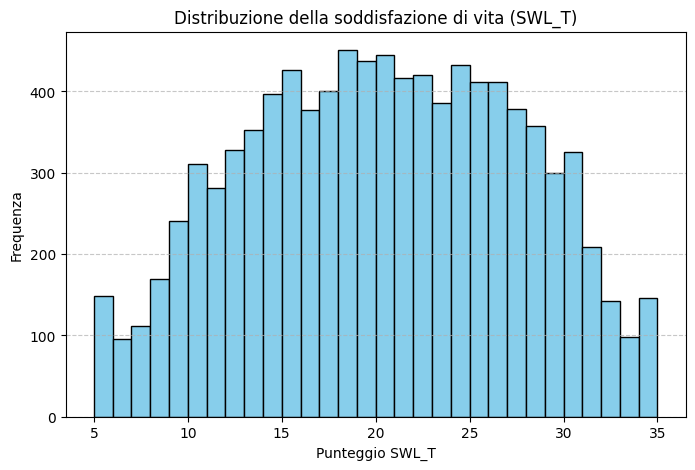

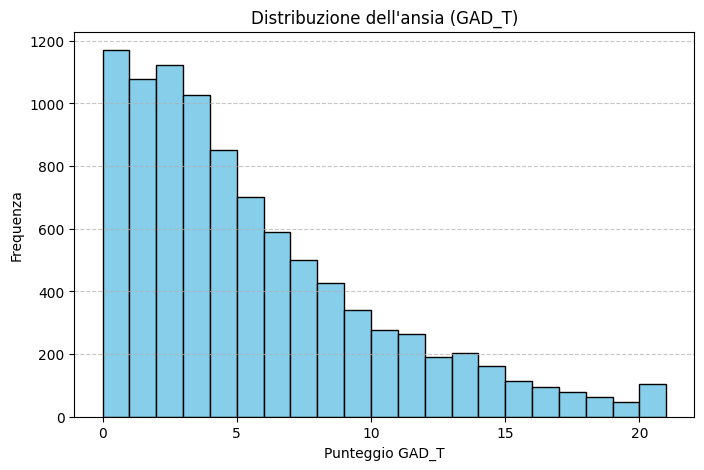

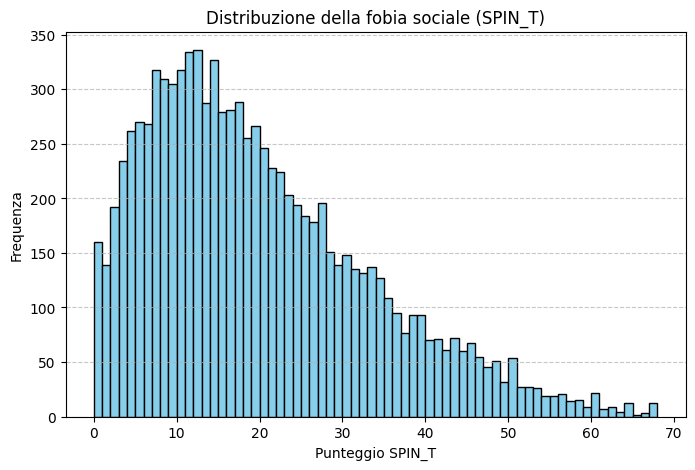

In [18]:
plt.figure(figsize=(8,5))   
plt.hist(lol_dataset['SWL_T'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribuzione della soddisfazione di vita (SWL_T)')
plt.xlabel('Punteggio SWL_T')
plt.ylabel('Frequenza')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
plt.figure(figsize=(8,5))   
plt.hist(lol_dataset['GAD_T'], bins=21, color='skyblue', edgecolor='black')
plt.title('Distribuzione dell\'ansia (GAD_T)')
plt.xlabel('Punteggio GAD_T')
plt.ylabel('Frequenza')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
plt.figure(figsize=(8,5))   
plt.hist(lol_dataset['SPIN_T'], bins=68, color='skyblue', edgecolor='black')
plt.title('Distribuzione della fobia sociale (SPIN_T)')
plt.xlabel('Punteggio SPIN_T')
plt.ylabel('Frequenza')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

La variabile target SWL_T presenta una distribuzione approssimativamente normale, centrata intorno ai valori medi. Ciò suggerisce che il campione è bilanciato e che i modelli di regressione lineare sono appropriati per la predizione del livello di soddisfazione di vita.

Distribuzione delle League

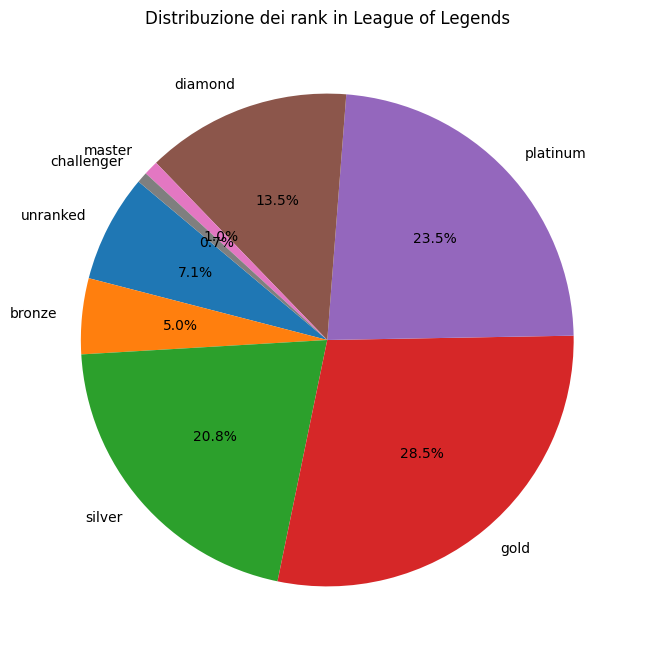

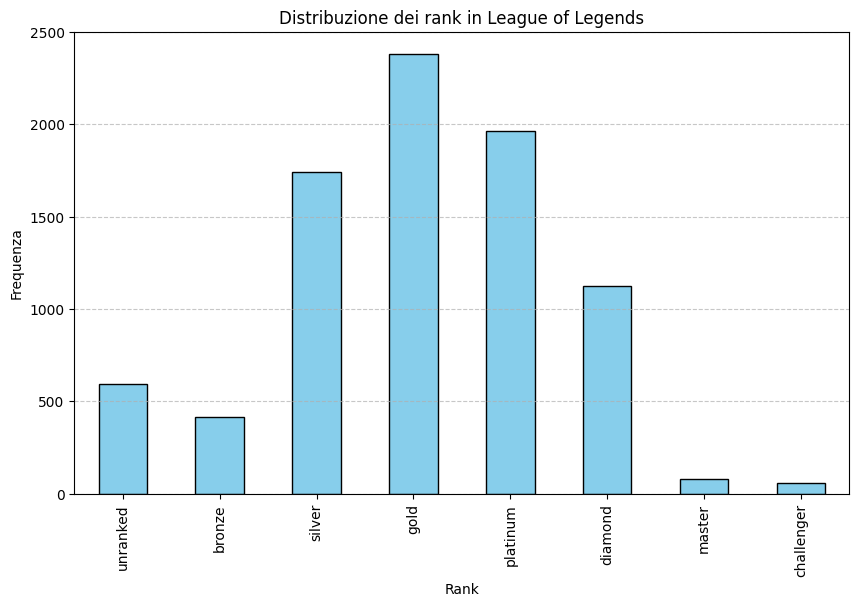

In [19]:
league_counts = lol_dataset['League'].value_counts().sort_index(key=lambda x: x.map(league_order))
league_counts.plot(kind='pie', autopct='%1.1f%%', startangle=140, figsize=(8,8))
plt.title('Distribuzione dei rank in League of Legends')
plt.ylabel('')
plt.show()
league_counts.plot(kind='bar', color='skyblue', edgecolor='black', figsize=(10,6))
plt.title('Distribuzione dei rank in League of Legends')
plt.xlabel('Rank')
plt.ylabel('Frequenza')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Il grafico mostra che i livelli di competitività più alti hanno meno frequenza e che in media i giocatori di questo dataset si trovano tra silver, gold e platinum.

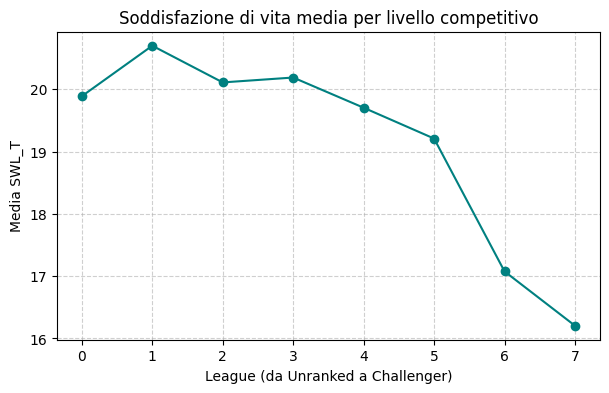

In [20]:
avg_swl = lol_dataset.groupby('League_num')['SWL_T'].mean()

plt.figure(figsize=(7,4))
plt.plot(avg_swl.index, avg_swl.values, marker='o', color='teal')
plt.title('Soddisfazione di vita media per livello competitivo')
plt.xlabel('League (da Unranked a Challenger)')
plt.ylabel('Media SWL_T')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

Il grafico mostra che all'aumentare del rank la soddisfazione di vita media diminuisce, ma potrebbe esserci un bias per colpa di pochi giocatori con rango alto.

## Correlazioni

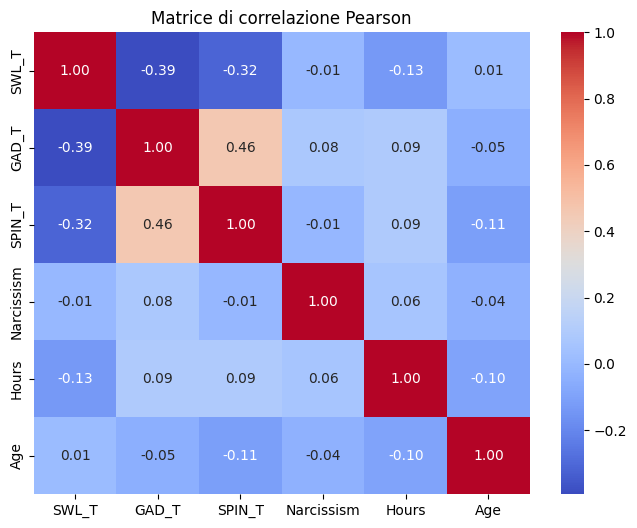

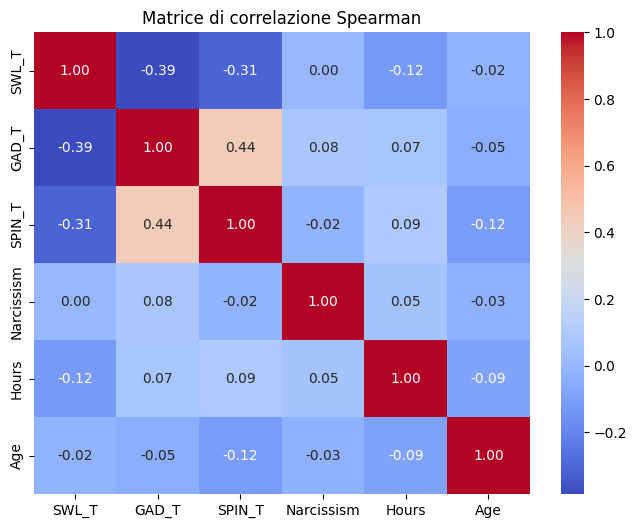

In [21]:
val = ['SWL_T', 'GAD_T', 'SPIN_T', 'Narcissism', 'Hours', 'Age']
corr_matrix = lol_dataset[val].corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matrice di correlazione Pearson")
plt.show()
corr_matrix_spearman = lol_dataset[val].corr(method='spearman')
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix_spearman, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matrice di correlazione Spearman")
plt.show()

Dalla matrice di correlazione Pearson si può notare una correlazione negativa e moderata tra SWL_T (soddisfazione di vita) e SPIN_T, GAD_T. Invece si ha una correlazione negativa debole con le ore di gioco settimanali e quasi nulla per gli altri parametri.

# Modelli di regressione

### Preparazione
In questa fase vengono importate le librerie necessarie per la creazione dei modelli, viene effettuata la selezione delle variabili predittive e la standardizzazione di esse per la regressione lineare.

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Selezione delle variabili predittive
# Rimuovo colonne non numeriche o con troppe categorie
predictors = ['GAD_T', 'SPIN_T', 'Narcissism', 'Hours', 'Age', 'League_num', 'GADE_num']
# Aggiungo le colonne di One-Hot Encoding
predictors += dummies.columns.tolist()
# Controllo la disponibilità delle colonne
available_predictors = [col for col in predictors if col in lol_dataset.columns]
print("Predittori disponibili:", available_predictors)

# Preparo i dati
X = lol_dataset[available_predictors].copy()
y = lol_dataset['SWL_T'].copy()

# Rimuovo righe con valori mancanti
before_na = len(X)
mask = ~(X.isna().any(axis=1) | y.isna())
X = X[mask]
y = y[mask]
print(f"Campioni dopo rimozione NA: {len(X)} (erano {before_na})")

# Split train/test
# Primo split -> 80% train, 20% temp
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)

# Secondo split -> 10% val, 10% test
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
print(f"Training set: {len(X_train)}, Test set: {len(X_test)}, Validation set: {len(X_val)}")

# Standardizzazione per la regressione lineare
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_val_scaled = scaler.transform(X_val)

Predittori disponibili: ['GAD_T', 'SPIN_T', 'Narcissism', 'Hours', 'Age', 'League_num', 'GADE_num', 'Degree_Bachelor (or equivalent)', 'Degree_High school diploma (or equivalent)', 'Degree_Master (or equivalent)', 'Degree_Ph.D., Psy. D., MD (or equivalent)', 'Work_Employed', 'Work_Student at college / university', 'Work_Student at school', 'Work_Unemployed / between jobs']
Campioni dopo rimozione NA: 7938 (erano 9402)
Training set: 6350, Test set: 794, Validation set: 794


### Regressione Lineare

In [23]:
# MODELLO 1: Regressione Lineare
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

# Predizioni
y_pred_lr_val = lr_model.predict(X_val_scaled)
y_pred_lr_test = lr_model.predict(X_test_scaled)

# Metriche per Regressione Lineare
print("=== REGRESSIONE LINEARE ===")
print(f"R² Validation: {r2_score(y_val, y_pred_lr_val):.4f}")
print(f"RMSE Validation: {np.sqrt(mean_squared_error(y_val, y_pred_lr_val)):.4f}")
print(f"MAE Validation: {mean_absolute_error(y_val, y_pred_lr_val):.4f}")

# Coefficienti
print("\nCoefficienti:")
coef_df = pd.DataFrame({
    'Feature': available_predictors,
    'Coefficient': lr_model.coef_
}).sort_values('Coefficient', key=abs, ascending=False)
print(coef_df)

=== REGRESSIONE LINEARE ===
R² Validation: 0.2599
RMSE Validation: 5.8710
MAE Validation: 4.7499

Coefficienti:
                                       Feature  Coefficient
0                                        GAD_T    -1.482299
14              Work_Unemployed / between jobs    -1.218935
6                                     GADE_num    -1.046770
1                                       SPIN_T    -0.973253
12        Work_Student at college / university     0.420323
5                                   League_num    -0.411393
4                                          Age    -0.400280
8   Degree_High school diploma (or equivalent)    -0.398865
3                                        Hours    -0.378870
9                Degree_Master (or equivalent)     0.327834
10   Degree_Ph.D., Psy. D., MD (or equivalent)     0.263780
13                      Work_Student at school     0.237633
11                               Work_Employed     0.223099
7              Degree_Bachelor (or equivalent)  

### Random Forest

In [24]:
# MODELLO 2: Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, max_depth=10)
rf_model.fit(X_train, y_train)

# Predizioni
y_pred_rf_val = rf_model.predict(X_val)

# Metriche per Random Forest
print("\n=== RANDOM FOREST ===")
print(f"R² Validation: {r2_score(y_val, y_pred_rf_val):.4f}")
print(f"RMSE Validation: {np.sqrt(mean_squared_error(y_val, y_pred_rf_val)):.4f}")
print(f"MAE Validation: {mean_absolute_error(y_val, y_pred_rf_val):.4f}")

# Feature importance
print("\nImportanza delle variabili:")
importance_df = pd.DataFrame({
    'Feature': available_predictors,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)
print(importance_df)


=== RANDOM FOREST ===
R² Validation: 0.2308
RMSE Validation: 5.9853
MAE Validation: 4.8496

Importanza delle variabili:
                                       Feature  Importance
0                                        GAD_T    0.310416
1                                       SPIN_T    0.161434
3                                        Hours    0.109483
14              Work_Unemployed / between jobs    0.104137
6                                     GADE_num    0.077591
4                                          Age    0.075802
5                                   League_num    0.058871
2                                   Narcissism    0.043655
8   Degree_High school diploma (or equivalent)    0.017397
12        Work_Student at college / university    0.009511
7              Degree_Bachelor (or equivalent)    0.008570
11                               Work_Employed    0.008194
9                Degree_Master (or equivalent)    0.008125
13                      Work_Student at school    0.0

### Gradient Boosting

#### GradientBoostingRegressor da sklearn.ensemble

In [25]:
gb_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
gb_model.fit(X_train, y_train)

# Predizioni
y_pred_gb_val = gb_model.predict(X_val)

r2_gb = r2_score(y_val, y_pred_gb_val)

# Metriche per Gradient Boosting
print("\n=== GRADIENT BOOSTING ===")
print(f"R² Validation: {r2_gb:.4f}")
print(f"RMSE Validation: {np.sqrt(mean_squared_error(y_val, y_pred_gb_val)):.4f}")
print(f"MAE Validation: {mean_absolute_error(y_val, y_pred_gb_val):.4f}")

# Feature importance
print("\nImportanza delle variabili (Gradient Boosting):")
importance_gb_df = pd.DataFrame({
    'Feature': available_predictors,
    'Importance': gb_model.feature_importances_
}).sort_values('Importance', ascending=False)
print(importance_gb_df)


=== GRADIENT BOOSTING ===
R² Validation: 0.2421
RMSE Validation: 5.9412
MAE Validation: 4.7829

Importanza delle variabili (Gradient Boosting):
                                       Feature  Importance
0                                        GAD_T    0.345573
1                                       SPIN_T    0.144082
14              Work_Unemployed / between jobs    0.125455
6                                     GADE_num    0.109418
3                                        Hours    0.081852
4                                          Age    0.067975
5                                   League_num    0.041008
2                                   Narcissism    0.028202
8   Degree_High school diploma (or equivalent)    0.021843
12        Work_Student at college / university    0.010834
11                               Work_Employed    0.007258
9                Degree_Master (or equivalent)    0.005917
7              Degree_Bachelor (or equivalent)    0.004676
10   Degree_Ph.D., Psy. D., M

#### XGBoost Regressor da xgboost

In [26]:
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42, objective='reg:squarederror')
xgb_model.fit(X_train, y_train)

# Predizioni
y_pred_xgb_val = xgb_model.predict(X_val)


r2_xgb = r2_score(y_val, y_pred_xgb_val)

# Metriche per XGBoost
print("\n=== XGBOOST ===")
print(f"R² Validation: {r2_xgb:.4f}")
print(f"RMSE Validation: {np.sqrt(mean_squared_error(y_val, y_pred_xgb_val)):.4f}")
print(f"MAE Validation: {mean_absolute_error(y_val, y_pred_xgb_val):.4f}")

# Feature importance
print("\nImportanza delle variabili (XGBoost):")
importance_xgb_df = pd.DataFrame({
    'Feature': available_predictors,
    'Importance': xgb_model.feature_importances_
}).sort_values('Importance', ascending=False)
print(importance_xgb_df)


=== XGBOOST ===
R² Validation: 0.2448
RMSE Validation: 5.9309
MAE Validation: 4.7685

Importanza delle variabili (XGBoost):
                                       Feature  Importance
14              Work_Unemployed / between jobs    0.285648
6                                     GADE_num    0.165744
0                                        GAD_T    0.141972
8   Degree_High school diploma (or equivalent)    0.067920
1                                       SPIN_T    0.042589
7              Degree_Bachelor (or equivalent)    0.039345
12        Work_Student at college / university    0.038357
3                                        Hours    0.032471
4                                          Age    0.031102
9                Degree_Master (or equivalent)    0.029511
5                                   League_num    0.028274
11                               Work_Employed    0.026009
2                                   Narcissism    0.025856
13                      Work_Student at school   

#### Confronto
Tra i due modelli vediamo che XGBoost ha una performance migliore

In [27]:
pct_change = ((r2_xgb - r2_gb) / abs(r2_gb)) * 100 if r2_gb != 0 else float('inf')
print(f"R² Validation XGBoost: {r2_xgb:.4f}")
print(f"R² Validation Gradient Boosting: {r2_gb:.4f}")
print(f"\nVariazione percentuale di R² tra XGBoost e Gradient Boosting: {pct_change:.2f}%")

R² Validation XGBoost: 0.2448
R² Validation Gradient Boosting: 0.2421

Variazione percentuale di R² tra XGBoost e Gradient Boosting: 1.09%


# Ricerca degli iperparametri

È stata effettuata una ricerca degli iperparametri esaustiva tramite Grid search. Per entrambi i metodi si è usata la metrica r2 per il parametro scoring

In [28]:
from sklearn.model_selection import GridSearchCV

### Random Forest

In [29]:
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10]
}

grid_search_rf = GridSearchCV(rf_model, param_grid_rf, cv=5, scoring='r2', n_jobs=-1, verbose=1)
grid_search_rf.fit(X_train, y_train)

print("Migliori iperparametri per Random Forest:", grid_search_rf.best_params_)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Migliori iperparametri per Random Forest: {'max_depth': 5, 'min_samples_split': 10, 'n_estimators': 200}


In [30]:
best_rf = grid_search_rf.best_estimator_
y_pred_best_rf = best_rf.predict(X_val)

print("\n=== Random Forest Ottimizzato Validation set ===")
print(f"R² Validation: {r2_score(y_val, y_pred_best_rf):.4f}")
print(f"RMSE Validation: {np.sqrt(mean_squared_error(y_val, y_pred_best_rf)):.4f}")
print(f"MAE Validation: {mean_absolute_error(y_val, y_pred_best_rf):.4f}")


=== Random Forest Ottimizzato Validation set ===
R² Validation: 0.2393
RMSE Validation: 5.9523
MAE Validation: 4.8567


In [31]:
y_pred_best_rf_test = best_rf.predict(X_test)
print("\n=== Random Forest Ottimizzato Test set ===")
print(f"R² Test: {r2_score(y_test, y_pred_best_rf_test):.4f}")
print(f"RMSE Test: {np.sqrt(mean_squared_error(y_test, y_pred_best_rf_test)):.4f}")
print(f"MAE Test: {mean_absolute_error(y_test, y_pred_best_rf_test):.4f}")


=== Random Forest Ottimizzato Test set ===
R² Test: 0.2694
RMSE Test: 6.3295
MAE Test: 5.1940


### XGBoost

In [32]:
param_grid_xgb = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.005, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}

grid_search_xgb = GridSearchCV(xgb_model, param_grid_xgb, cv=5, scoring='r2', n_jobs=-1, verbose=1)
grid_search_xgb.fit(X_train, y_train)

print("Migliori iperparametri per XGBoost:", grid_search_xgb.best_params_)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Migliori iperparametri per XGBoost: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100}


In [33]:
best_xgb = grid_search_xgb.best_estimator_
y_pred_best_xgb = best_xgb.predict(X_val)

print("\n=== XGBOOST Ottimizzato Validation set ===")
print(f"R² Validation: {r2_score(y_val, y_pred_best_xgb):.4f}")
print(f"RMSE Validation: {np.sqrt(mean_squared_error(y_val, y_pred_best_xgb)):.4f}")
print(f"MAE Validation: {mean_absolute_error(y_val, y_pred_best_xgb):.4f}")


=== XGBOOST Ottimizzato Validation set ===
R² Validation: 0.2658
RMSE Validation: 5.8475
MAE Validation: 4.7433


In [34]:
y_pred_best_xgb_test = best_xgb.predict(X_test)

print("\n=== XGBOOST Ottimizzato Test set ===")
print(f"R² Test: {r2_score(y_test, y_pred_best_xgb_test):.4f}")
print(f"RMSE Test: {np.sqrt(mean_squared_error(y_test, y_pred_best_xgb_test)):.4f}")
print(f"MAE Test: {mean_absolute_error(y_test, y_pred_best_xgb_test):.4f}")


=== XGBOOST Ottimizzato Test set ===
R² Test: 0.2805
RMSE Test: 6.2812
MAE Test: 5.1091


# Interpretazione dei risultati

**Modelli implementati:**
1. **Regressione Lineare**: modello lineare semplice con standardizzazione delle variabili
2. **Random Forest**: ensemble di alberi decisionali per catturare relazioni non lineari

**Variabili predittive utilizzate:**
- Fattori psicologici: GAD_T (ansia), SPIN_T (fobia sociale), Narcissism
- Comportamento di gioco: Hours (ore settimanali), League_num (livello competitivo)
- Demografiche: Age, Degree_code, Work_code, GADE_code

**Metriche di valutazione:**
- **R²**: coefficiente di determinazione (varianza spiegata dal modello)
- **RMSE**: errore quadratico medio (in unità di SWL_T)
- **MAE**: errore assoluto medio

**Analisi dei grafici:**
- I grafici scatter mostrano la correlazione tra valori predetti e reali
- I residui dovrebbero essere distribuiti casualmente intorno allo zero
- L'importanza delle variabili nel Random Forest indica quali fattori influenzano maggiormente la soddisfazione di vita

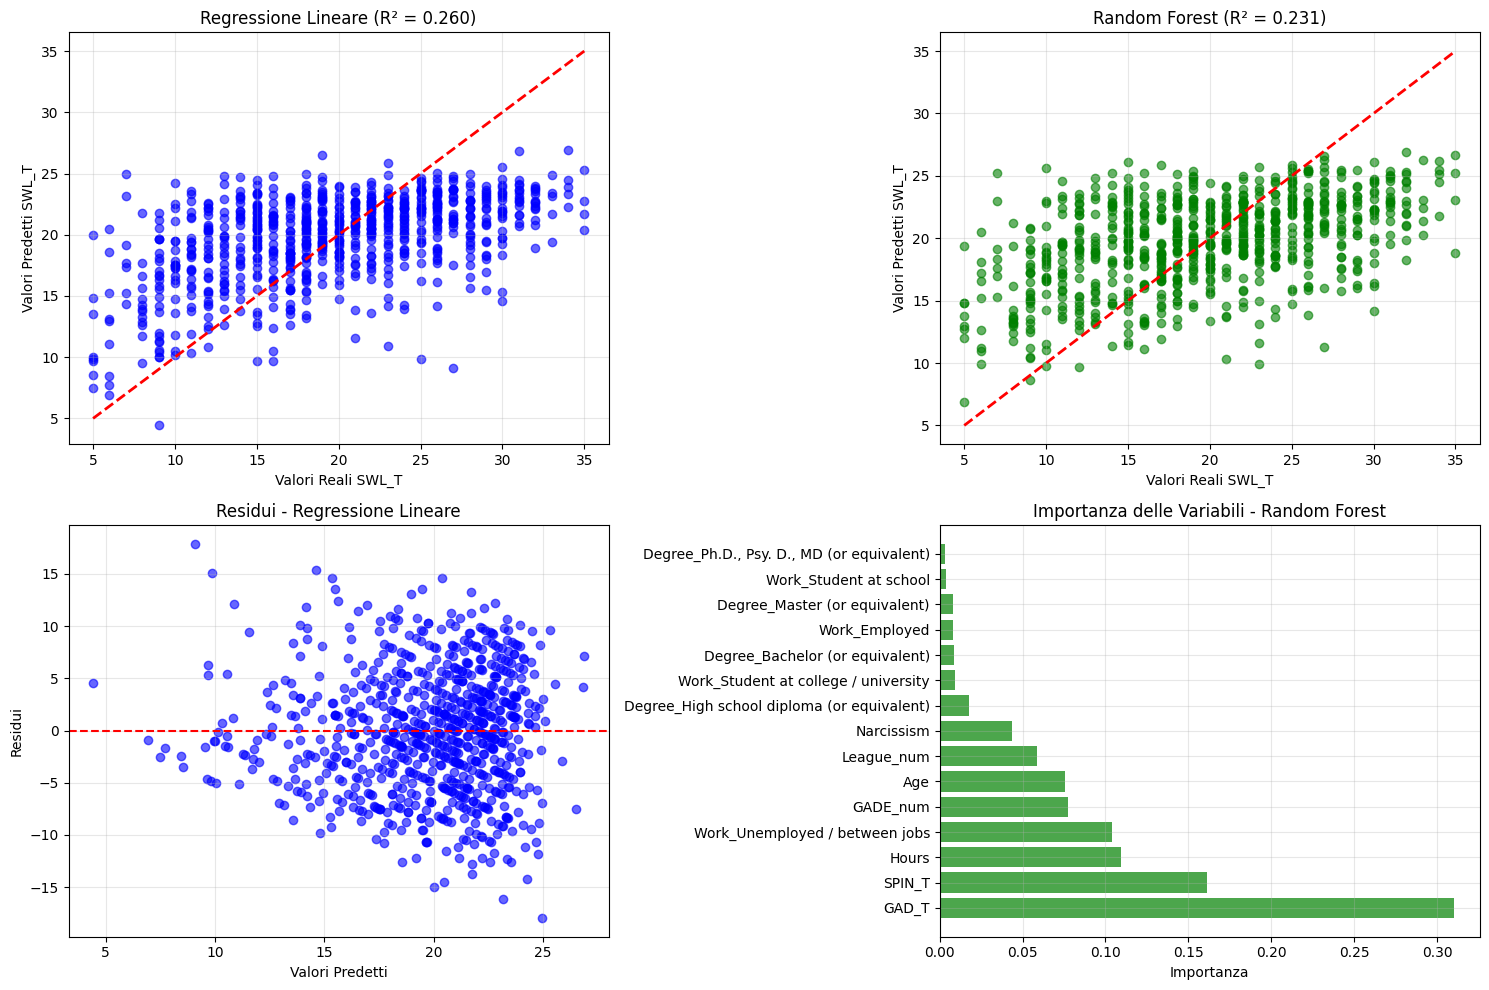

In [35]:
# Visualizzazione dei risultati
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Valori predetti vs valori reali - Regressione Lineare
axes[0,0].scatter(y_val, y_pred_lr_val, alpha=0.6, color='blue')
axes[0,0].plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2)
axes[0,0].set_xlabel('Valori Reali SWL_T')
axes[0,0].set_ylabel('Valori Predetti SWL_T')
axes[0,0].set_title(f'Regressione Lineare (R² = {r2_score(y_val, y_pred_lr_val):.3f})')
axes[0,0].grid(True, alpha=0.3)

# 2. Valori predetti vs valori reali - Random Forest
axes[0,1].scatter(y_val, y_pred_rf_val, alpha=0.6, color='green')
axes[0,1].plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2)
axes[0,1].set_xlabel('Valori Reali SWL_T')
axes[0,1].set_ylabel('Valori Predetti SWL_T')
axes[0,1].set_title(f'Random Forest (R² = {r2_score(y_val, y_pred_rf_val):.3f})')
axes[0,1].grid(True, alpha=0.3)

# 3. Residui - Regressione Lineare
residuals_lr = y_val - y_pred_lr_val
axes[1,0].scatter(y_pred_lr_val, residuals_lr, alpha=0.6, color='blue')
axes[1,0].axhline(y=0, color='r', linestyle='--')
axes[1,0].set_xlabel('Valori Predetti')
axes[1,0].set_ylabel('Residui')
axes[1,0].set_title('Residui - Regressione Lineare')
axes[1,0].grid(True, alpha=0.3)

# 4. Feature Importance - Random Forest
importance_df_plot = importance_df
axes[1,1].barh(importance_df_plot['Feature'], importance_df_plot['Importance'], color='green', alpha=0.7)
axes[1,1].set_xlabel('Importanza')
axes[1,1].set_title('Importanza delle Variabili - Random Forest')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [36]:
# Coefficienti
print("\nCoefficienti regressione lineare:")
coef_df = pd.DataFrame({
    'Feature': available_predictors,
    'Coefficient': lr_model.coef_
}).sort_values('Coefficient', key=abs, ascending=False)
print(coef_df)


Coefficienti regressione lineare:
                                       Feature  Coefficient
0                                        GAD_T    -1.482299
14              Work_Unemployed / between jobs    -1.218935
6                                     GADE_num    -1.046770
1                                       SPIN_T    -0.973253
12        Work_Student at college / university     0.420323
5                                   League_num    -0.411393
4                                          Age    -0.400280
8   Degree_High school diploma (or equivalent)    -0.398865
3                                        Hours    -0.378870
9                Degree_Master (or equivalent)     0.327834
10   Degree_Ph.D., Psy. D., MD (or equivalent)     0.263780
13                      Work_Student at school     0.237633
11                               Work_Employed     0.223099
7              Degree_Bachelor (or equivalent)     0.213388
2                                   Narcissism     0.177160


Il modelli di regressione lineare e Random Forest mostrano una precisione simile, con R<sup>2</sup> = 0.251. Sebbene sia un valore basso, negli studi psicologici è un valore aspettato poiché il comportamento umano è influenzato da moltissime variabili. Una meta-analisi su oltre 25.000 studi di psicologia sociale[<sup>(3)</sup>](#ref-richard2003) ha mostrato che l’effetto medio osservato in questo campo corrisponde a circa 0.21.

I coefficienti di regressione lineare mostrano principalmente una relazione inversa con la soddisfazione di vita. Questo indica che all'aumentare di una caratteristica si ha la diminuzione della variabile target. In altre parole, l'aumentare dell'ansia (primo coefficiente in tabella) diminuisce la soddisfazione di vita. Si vede inoltre che lo stato di occupazione (Work_code) è più determinante rispetto alla fobia sociale (SPIN_T).


L'importanza delle variabili data dalla Random Forest mostra che l'ansia (GAD) ha una forte importanza sulla soddisfazione di vita, raggiungendo il valore di 0.35. Segue l'ansia sociale (SPIN_T) che contribuisce del 0.15, lo stato di occupazione (Work_code) di 0.12 e a discendere le ore settimanali giocate (Hours) del 0.10.
Questo è intuitivamente vero anche nella realtà: l'ansia ha grossa conseguenza sulla soddisfazione di vita, ma è interessante notare come l'occupazione possa influire, mentre le variabili come League hanno meno importanza.
In confronto ai coefficienti di regressione lineare, la random forest dà più importanza a SPIN_T rispetto a Work_code.

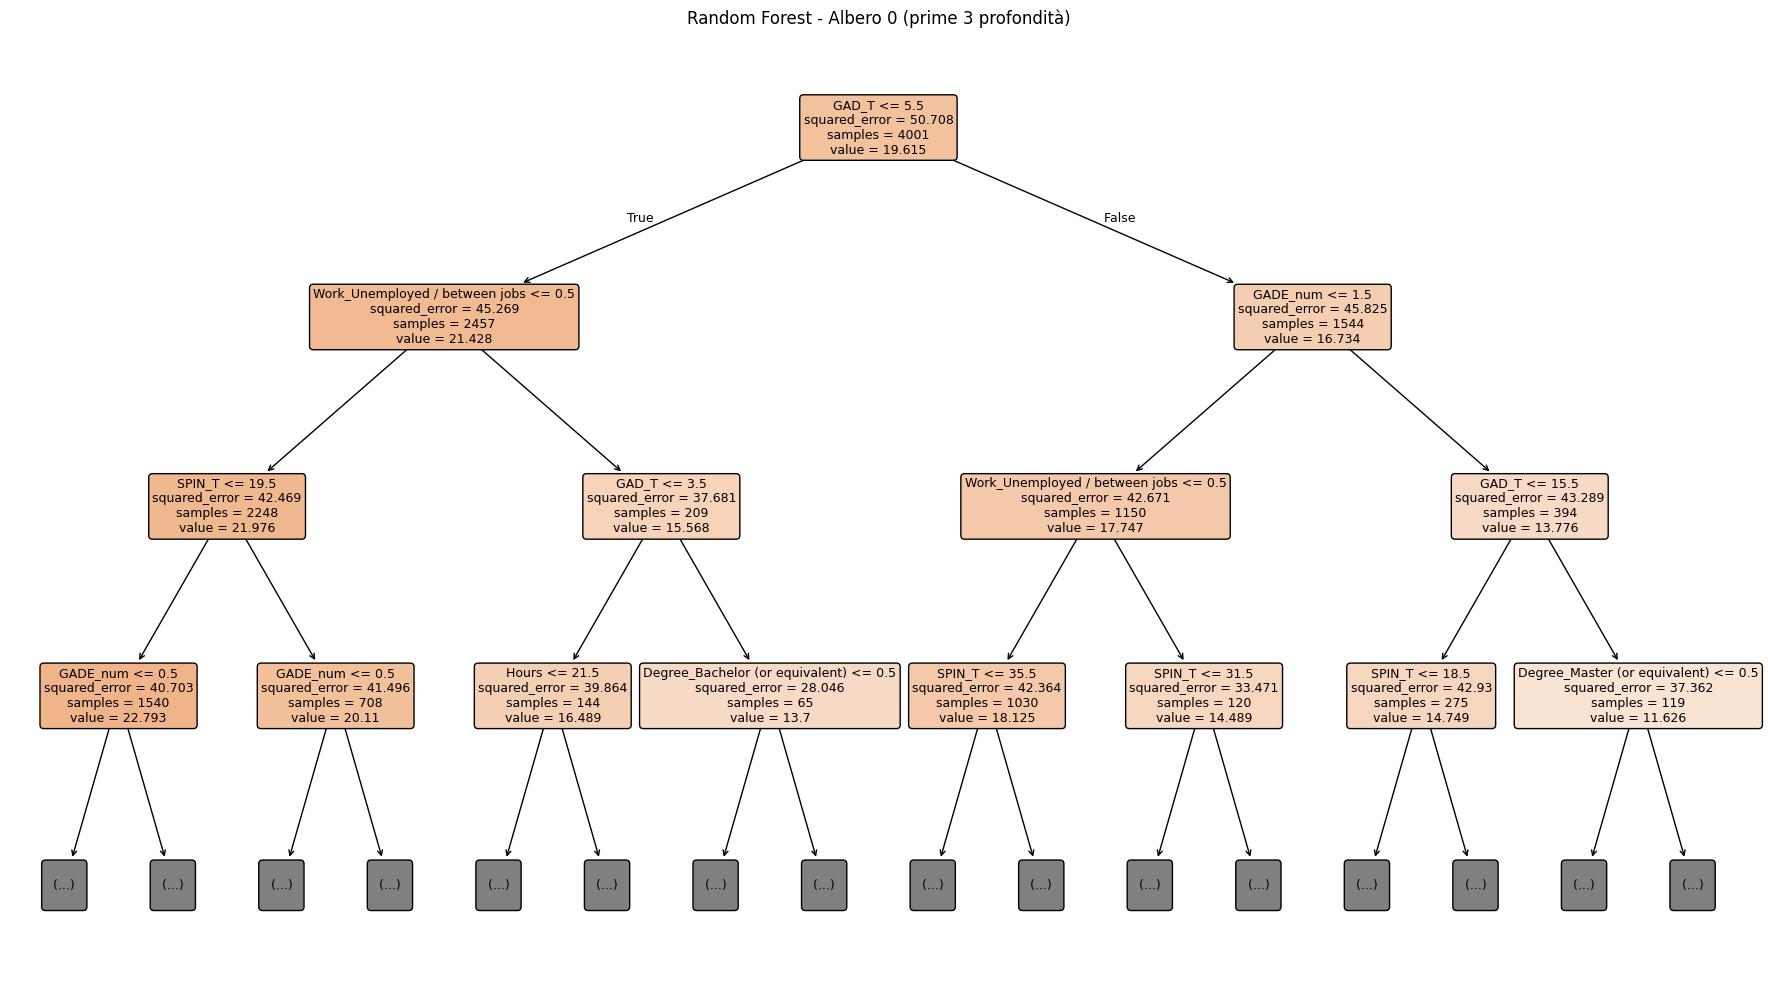

In [37]:
# Visualizza i primi livelli di un albero della Random Forest
from sklearn.tree import plot_tree, export_text

# Parametri regolabili
tree_idx = 0       # cambia per ispezionare un altro albero (0..n_estimators-1)
max_levels = 3     # quanti livelli superiori visualizzare

# Recupera un albero dalla foresta
estimator = rf_model.estimators_[tree_idx]
feature_names = list(available_predictors)

# Grafico dell'albero limitato ai primi livelli
plt.figure(figsize=(18, 10))
plot_tree(
    estimator,
    feature_names=feature_names,
    class_names=None,
    filled=True,
    rounded=True,
    impurity=True,
    proportion=False,
    max_depth=max_levels,
    fontsize=9
)
plt.title(f"Random Forest - Albero {tree_idx} (prime {max_levels} profondità)")
plt.tight_layout()
plt.show()

Questa immagine mostra il funzionamento del modello regressivo Random Forest. Viene illustrato il primo albero e formulati alcuni criteri, il cui primo è sul valore GAD_T. Avviene quindi lo split sui dati, tra quelli che soddisfano la condizione e non, dopodiché continuano ulteriori domande fino a raggiungere i nodi foglia. Arrivati ad essi viene eseguita la predizione, che viene confrontata quella degli altri alberi, fino ad arrivare a una soluzione.

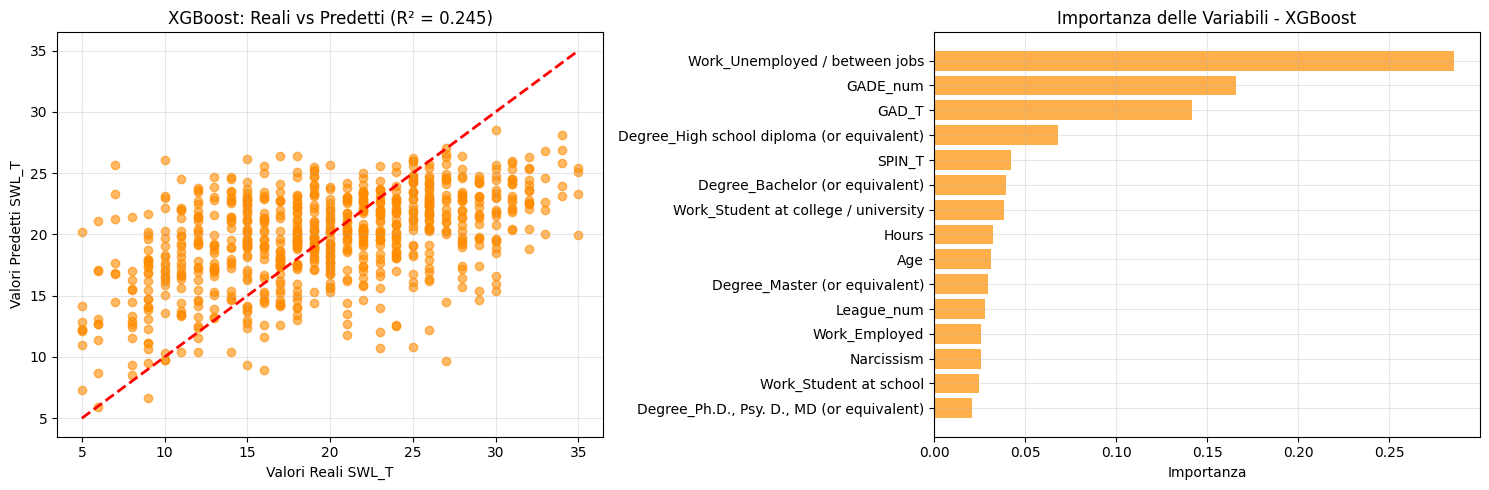

In [38]:
# Grafici XGBoost: Valori reali vs predetti e Importanza variabili
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# 1) Valori predetti vs reali - XGBoost
axes[0].scatter(y_val, y_pred_xgb_val, alpha=0.6, color='darkorange')
axes[0].plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2)
axes[0].set_xlabel('Valori Reali SWL_T')
axes[0].set_ylabel('Valori Predetti SWL_T')
axes[0].set_title(f'XGBoost: Reali vs Predetti (R² = {r2_score(y_val, y_pred_xgb_val):.3f})')
axes[0].grid(True, alpha=0.3)

# 2) Importanza delle variabili - XGBoost
importance_xgb_plot = importance_xgb_df
axes[1].barh(importance_xgb_plot['Feature'], importance_xgb_plot['Importance'], color='darkorange', alpha=0.7)
axes[1].invert_yaxis()  # feature più importanti in alto
axes[1].set_xlabel('Importanza')
axes[1].set_title('Importanza delle Variabili - XGBoost')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Con XGBoost vediamo un aumento di precisione (R<sup>2</sup>=0.267) che si allinea con il report scientifico[<sup>(2)</sup>](#ref-oparina) che afferma il Gradient Boosting come miglior algoritmo tree-based per la previsione del benessere umano.

A differenza dei precedenti modelli, in XGB l'importanza delle variabili GAD_T e Work_code sono molto più vicine attorno allo 0.25. Inoltre, sale di classifica il fattore **GADE**, l'effetto del gaming sul lavoro che supera anche lo SPIN_T. 

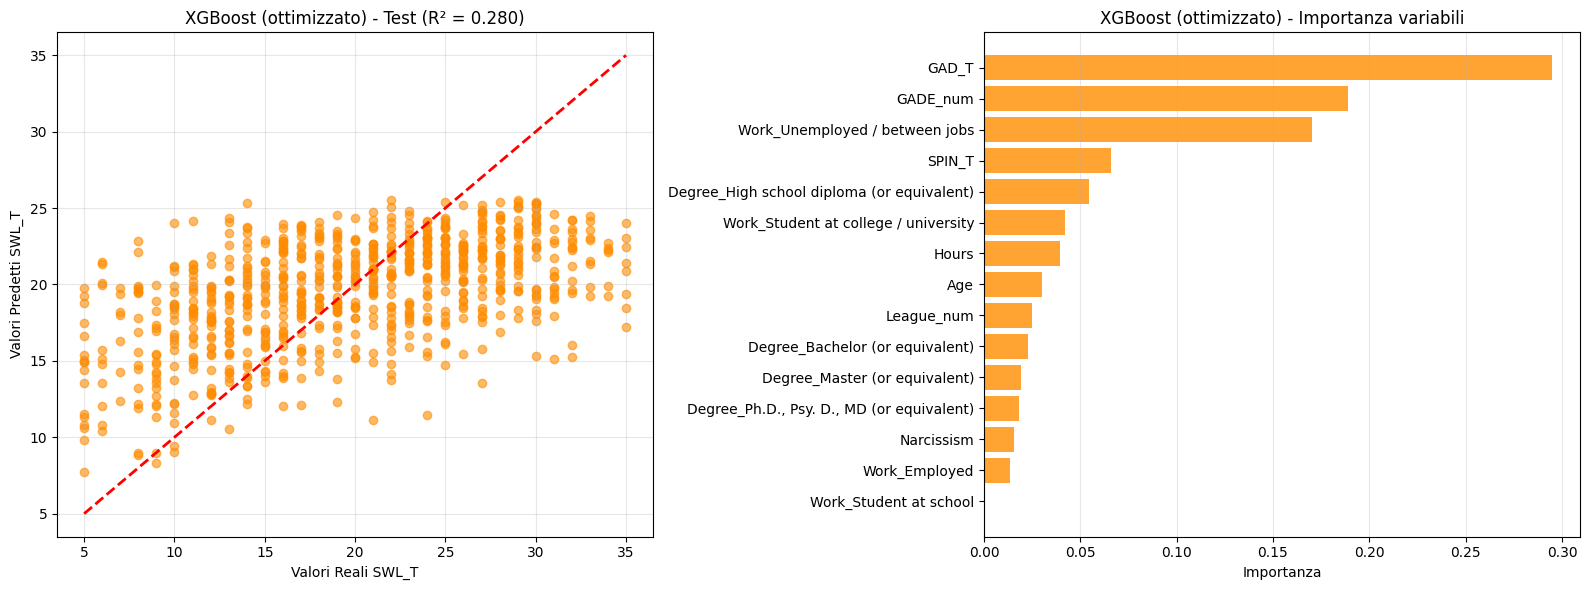

In [39]:
importance_best_xgb_df = pd.DataFrame({
    'Feature': available_predictors,
    'Importance': best_xgb.feature_importances_
}).sort_values('Importance', ascending=False)

# Figure: scatter Reali vs Predetti + Importanze (1 riga, 2 colonne)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 3) XGB ottimizzato: Reali vs Predetti
axes[0].scatter(y_test, y_pred_best_xgb_test, alpha=0.6, color='darkorange')
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0].set_xlabel('Valori Reali SWL_T')
axes[0].set_ylabel('Valori Predetti SWL_T')
axes[0].set_title(f'XGBoost (ottimizzato) - Test (R² = {r2_score(y_test, y_pred_best_xgb_test):.3f})')
axes[0].grid(True, alpha=0.3)

# 4) XGB ottimizzato: Importanza variabili
axes[1].barh(importance_best_xgb_df['Feature'], importance_best_xgb_df['Importance'], color='darkorange', alpha=0.8)
axes[1].invert_yaxis()
axes[1].set_xlabel('Importanza')
axes[1].set_title('XGBoost (ottimizzato) - Importanza variabili')
axes[1].grid(True, axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

Dopo la ricerca degli iperparametri, XGBoost è stato ulteriormente migliorato raggiungendo R<sup>2</sup>=0.273 sul Test set. Questa versione ha dato molta più importanza al fattore GAD_T, superando lo 0.4. Il Work_code rimane al secondo posto mentre SPIN_T e GADE assumono valori pressoché uguali.

# Conclusioni

# Riferimenti bibliografici

1. OSF. (2017). Gaming Study Dataset [Dataset]. OSF. https://osf.io/vnbxk

2. Oparina, E., Kaiser, C., Gentile, N. et al. Machine learning in the prediction of human wellbeing. Sci Rep 15, 1632 (2025). https://doi.org/10.1038/s41598-024-84137-1 <span id="ref-oparina"></span>

3. Richard, F. D., Bond, C. F., & Stokes-Zoota, J. J. (2003). One Hundred Years of Social Psychology Quantitatively Described. Review of General Psychology, 7(4), 331-363. https://doi.org/10.1037/1089-2680.7.4.331 (Original work published 2003) <span id="ref-richard2003"></span>
